# Part 6: WaveNet

### 6.1 Base Code from prev. exercise (improved a bit)
As base, we will use the building blocks we created in the gradients exercise before:

In [5]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [6]:
words = open('names.txt', 'r', encoding='utf-8').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [7]:
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos.keys())
print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


__Note__: Increase block_size to 8 to increase the context size!

In [8]:
block_size = 8 # Offset of context

def build_dataset(words):
    X, Y = [], []
    for w in words:
        #print(w)
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            #print(''.join(itos[i] for i in context), '-->', itos[ix])
            context = context[1:] + [ix]
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

In [9]:
class Linear:

    def __init__(self, fan_in, fan_out, bias=True):
        self.weights = torch.randn((fan_in, fan_out)) / fan_in ** 0.5
        self.bias = torch.zeros(fan_out) if bias else None

    def __call__(self, x):
        self.out = x @ self.weights
        if self.bias is not None:
            self.out += self.bias
        return self.out

    def parameters(self):
        return [self.weights] + ([] if self.bias is None else [self.bias])

class BatchNorm1d:

    def __init__(self, dim, eps=1e-5, momentum=0.1):
        self.eps = eps
        self.momentum = momentum
        self.training = True
        # params
        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)
        # buffers
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)

    def __call__(self, x):
        if self.training:
            # Note that this diverges from torch standard, we have N,L,C and they use N,C,L!
            if x.ndim == 2:
                dim = 0
            elif x.ndim == 3:
                dim = (0, 1)
            xmean = x.mean(dim, keepdim=True)
            xvar = x.var(dim, keepdim=True, unbiased=True)
        else:
            xmean = self.running_mean
            xvar = self.running_var

        xhat = (x - xmean) / torch.sqrt(xvar + self.eps)
        self.out = self.gamma * xhat + self.beta

        # Update buffers
        if self.training:
            with torch.no_grad():
                self.running_mean = self.running_mean * (1 - self.momentum) + self.momentum * xmean
                self.running_var = self.running_var * (1 - self.momentum) + self.momentum * xvar
        return self.out

    def parameters(self):
        return [self.gamma, self.beta]

class Tanh:
    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out

    def parameters(self):
        return []

class Embedding:

    def __init__(self, num_embeddings, embedding_dim):
        self.weight = torch.randn((num_embeddings, embedding_dim))

    def __call__(self, IX):
        self.out = self.weight[IX]
        return self.out

    def parameters(self):
        return [self.weight]

class FlattenConsecutive:

    def __init__(self, n):
        """
        :param n: Number of consecutive character embeddings.
        """
        self.n = n

    def __call__(self, x):
        B, T, C = x.shape

        x = x.view(B, T // self.n, C*self.n)
        # Remove the 1 dim and proceed as before the re-write if we have a solo dim 1.
        if x.shape[1] == 1:
            x = x.squeeze(1)
        self.out = x
        return self.out

    def parameters(self):
        return []

class Sequential:

    def __init__(self, layers):
        self.layers = layers

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        self.out = x
        return self.out

    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]

__Note__: We discard the generator here by setting a manual seed for torch overall, which does the same thing
globally!

In [10]:
torch.manual_seed(42);

Initialise a very basic network as sanity check.

__Notes__:
* __Torch Containers__: We can use a torch container (ae. Sequential, ...) instead of a list for our layers. This just
passes the input to all the contained classes by using their __call__ property!

In [15]:
n_embd = 24
n_hidden = 128
g = torch.Generator().manual_seed(2147483647)

model = Sequential([
    Embedding(vocab_size, n_embd),
    FlattenConsecutive(2), Linear(n_embd * 2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    FlattenConsecutive(2), Linear(n_hidden * 2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    FlattenConsecutive(2), Linear(n_hidden * 2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, vocab_size)
])

# For intuition of the gain for initialisation look at the diagnostic plots below!!
with torch.no_grad():
    # make last layer less confident
    model.layers[-1].weights *= 0.1


parameters = model.parameters()
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True

76579


In [16]:
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
    # Create a minibatch from X
    ix = torch.randint(0, Xtr.shape[0], (batch_size,))
    Xb, Yb = Xtr[ix], Ytr[ix]

    # FORWARD PASS
    logits = model(Xb)
    loss = F.cross_entropy(logits, Yb)

    # BACKWARD PASS
    for p in parameters:
        p.grad = None
    loss.backward()

    lr = 0.1 if i < 100000 else 0.01 # LR decay
    for p in parameters:
        p.data += -lr * p.grad

    if i % 10000 == 0:
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')

    lossi.append(loss.log10().item())
    break # Comment out after debug

      0/ 200000: 3.3216


__Note__: __Loss plot very noisy, we will fix this now!!__

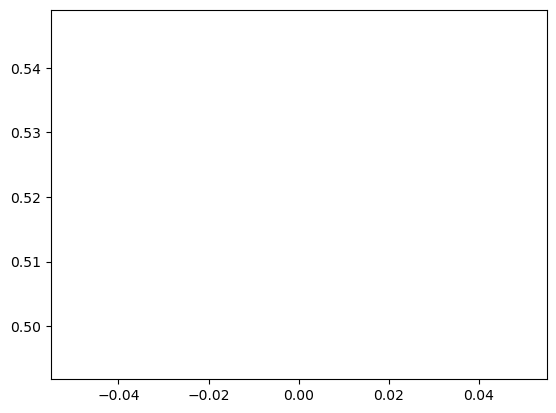

In [13]:
plt.plot(lossi);

#### 6.1.1 Fixing the noisy loss plot

We can see that if we average the loss representation over each 1000 batches
a nicer representation emerges. We can see the effect of the learning rate
decay at 100.000 steps, which drastically decreases the loss:

In [14]:
plt.plot(torch.tensor(lossi).view(-1, 1000).mean(1));

RuntimeError: shape '[-1, 1000]' is invalid for input of size 1

In [ ]:
for layer in model.layers:
    layer.training = False

In [ ]:
@torch.no_grad() # Decorate to remove gradient tracking
def split_loss(split):
    x, y = {
        'train': (Xtr, Ytr),
        'val': (Xdev, Ydev),
        'test': (Xte, Yte)
    }[split]
    logits = model(x)
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())

split_loss('train')
split_loss('val')

In [ ]:
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    out = []
    context = [0] * block_size
    while True:
        logits = model(torch.tensor([context]))
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, generator=g, num_samples=1).item()
        context = context[1:] + [ix]
        out.append(ix)

        if ix == 0:
            break
    print(''.join(itos[i] for i in out))

## 6.2 WaveNet: Scaling the MLP up

Since we see that the validation and training loss still do not diverge that much,
we can be sure that we do not overfit currently. Thus, we can increase the model
capacity by increasing its size (parameter count)!

__Since we crush our embeddings so fast, it would be nonsensical to increase the layer size
or increase the model depth.__

Therefore, we introduce the idea behind the WaveNet architecture, which __gradually decreases
the embedding size without the crush in the initial first layer!__
(This is similar to how a convolutional network functions)


__Notes__:
* __PyTorch matmal__: Is __very powerful!__ It can matmul tensors up to abitrary dimensions, as it
__only treats the last dimension as data dimensions__, with all before as batch dimension. This way,
we can ae. matmul a (4,5,2,3,80) tensor with a (80,200) tensor and get a (4,5,2,3,200) tensor as output!
* __Why Conv is more performant than a loop with linear kernels__: Convolutional layers get processed in
parallel directly by CUDA with a CUDA kernel. This is way faster than our current implementation!

__Andrej's tips for practice__:
* __Dev process__: Develop the code first in a juptier notebook to get shapes etc. right and be able
to interactively debug the training/model building process. Then copy the code over to actual python
scripts and make your experiment with the code there!
* __Experiments__: Do lots of optimizations with lots of plots for train/val, gradients, grid/random-search ...

__Intuition__:The idea is now using the pytorch matmul function in parallel to process bi-gram groups of our
characters contexts.